# Setup

In [1]:
%%capture

###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT','raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# recluster full adata for better louvain clusters
full_adata = process_adata(raw_adata)
pca_adata(full_adata, num_pcs=30)
umap_adata(full_adata, res=0.05)



# Gene module UMAPs: MEL vs KRT

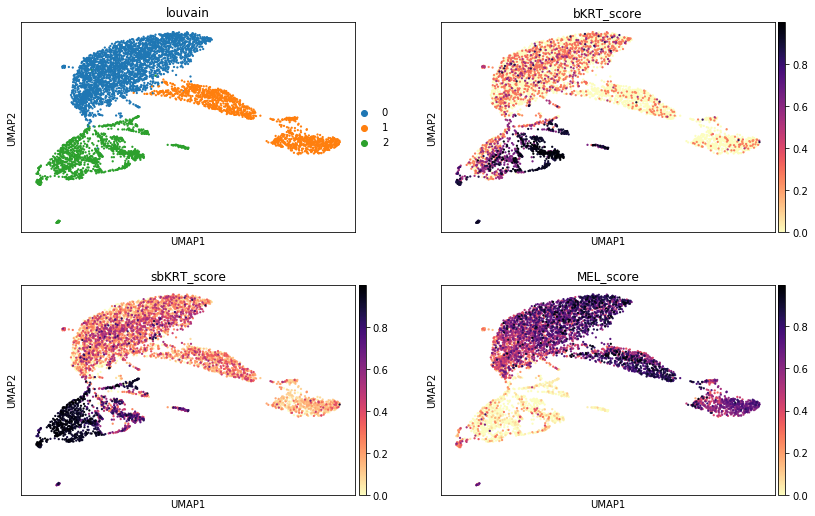

In [2]:
def greater_than (exp_vec):
    # percent rank
    return list(map(lambda x: stats.percentileofscore(exp_vec, x, kind='strict')/100, exp_vec))

#SORT_module = ['ITGA6','KIT','ITGAX']
MEL_module = ['PMEL','TYR','DCT','MITF','TYRP1','SOX10']
bKRT_module = ['ITGB4','KRT14','KRT5']
sbKRT_module = ['KRT1','KRT10','DSG1']


test_adata = full_adata
test_adata.obs['cell'] = test_adata.obs.index.tolist()
test_adata.obs['cell'] = (test_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(test_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(test_adata,
                 var_names = MEL_module+bKRT_module+sbKRT_module,
                 groupby = 'cell')
exp_df = exp_df.apply(greater_than, axis=0)
test_adata.obs['MEL_score'] = exp_df.loc[:,MEL_module].mean(axis=1)
test_adata.obs['bKRT_score'] = exp_df.loc[:,bKRT_module].mean(axis=1)
test_adata.obs['sbKRT_score'] = exp_df.loc[:,sbKRT_module].mean(axis=1)

sc.pl.umap(test_adata, color=['louvain','bKRT_score','sbKRT_score','MEL_score'], ncols = 2, cmap = 'magma_r')
# sc.pl.umap(full_adata, color=MEL_module)
# sc.pl.umap(full_adata, color=KRT_module)



# Gene module heatmaps: MEL vs KRT

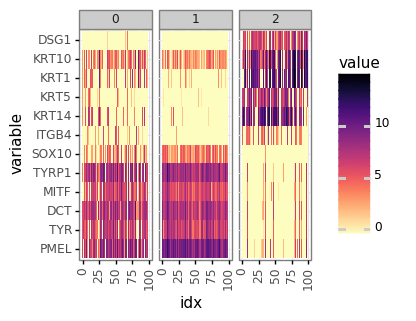

<ggplot: (-9223363310457528786)>


In [3]:
cat, exp_df = prepare_dataframe(test_adata,
                 var_names = MEL_module+bKRT_module+sbKRT_module,
                 groupby = 'cell')

exp_df['louvain'] = test_adata.obs.louvain.tolist()
# sample 100 cells from each louvain cluster
exp_df_melt = pd.melt((exp_df
                       .groupby('louvain')
                       .apply(lambda x: (x.sample(100)
                                         .assign(idx = lambda x: [i for i in range(len(x))])
                                        )
                             )
                      ), id_vars=['louvain','idx']
                     )
exp_df_melt['module'] = ['MEL' if x in MEL_module else 'KRT' for x in exp_df_melt.variable]
exp_df_melt['variable'] = (exp_df_melt['variable']
                           .astype(str)
                           .astype(CategoricalDtype(MEL_module+bKRT_module+sbKRT_module, ordered=True))
                          )

print(ggplot(exp_df_melt)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~louvain')
      + scale_fill_cmap('magma_r')
     )


# PCA and UMAPs on age and acr vs cut vs fsk

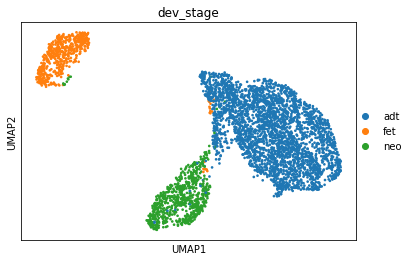

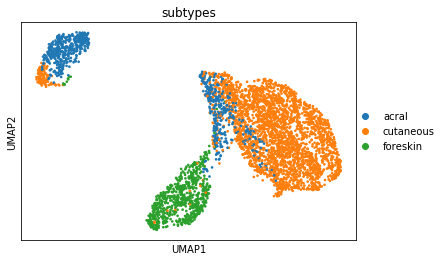

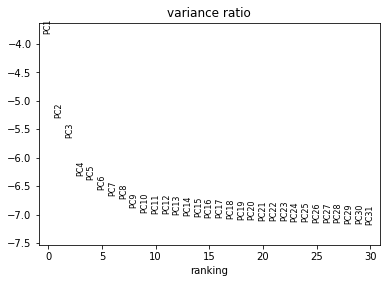

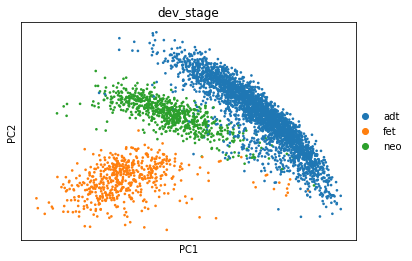

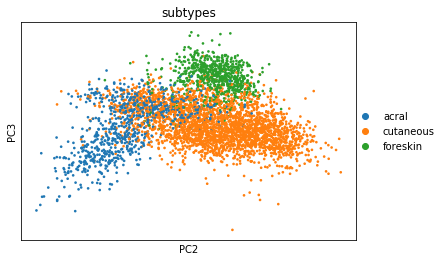

In [4]:
# simple output

adata_subset2.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in adata_subset2.obs.age]
adata_subset2.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in adata_subset2.obs.general_location]
adata_subset2.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(adata_subset2.obs.dev_stage, adata_subset2.obs.subtypes)]

sc.pl.umap(adata_subset2, color = ['dev_stage'])
sc.pl.umap(adata_subset2, color = ['subtypes'])
sc.pl.pca_variance_ratio(adata_subset2, log=True)
sc.pl.pca(adata_subset2, components=['1,2'], color=['dev_stage'])
sc.pl.pca(adata_subset2, components=['2,3'], color=['subtypes'])


dev_stage
   PC        f1
0   1  0.845827
1   2  0.746110
2   3  0.805516
3   4  0.698020
4   5  0.688119
5   6  0.688119
6   7  0.688119
7   8  0.688119
8   9  0.688119
9  10  0.688119


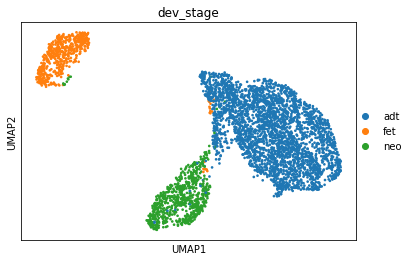

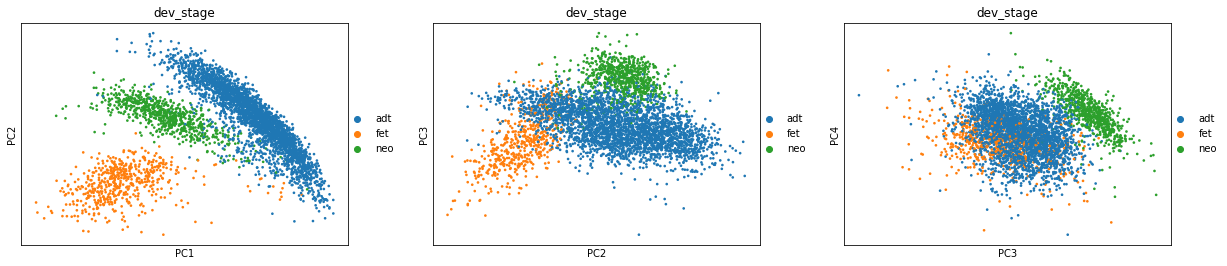

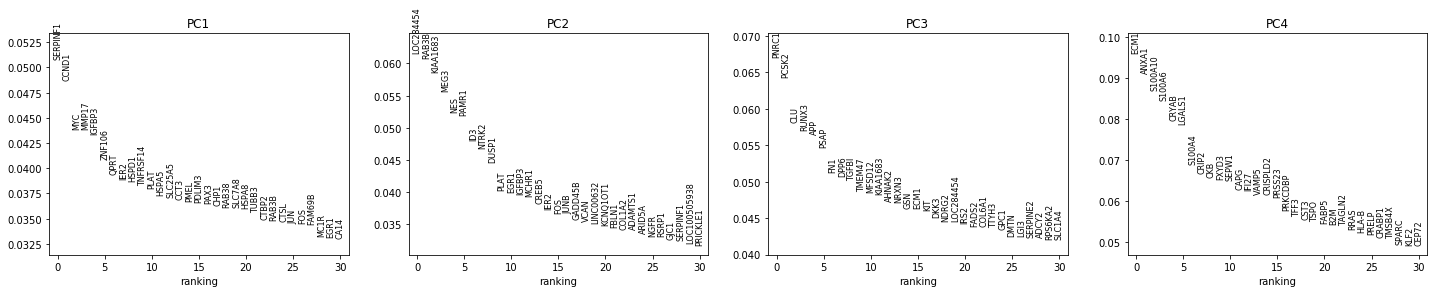

subtypes
   PC        f1
0   1  0.688119
1   2  0.725601
2   3  0.764498
3   4  0.661245
4   5  0.649222
5   6  0.648515
6   7  0.643564
7   8  0.647808
8   9  0.647100
9  10  0.647808


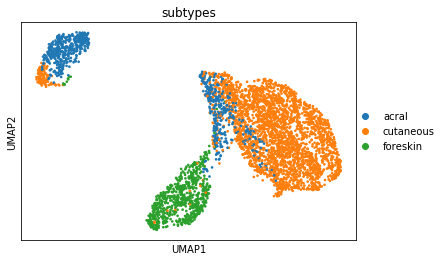

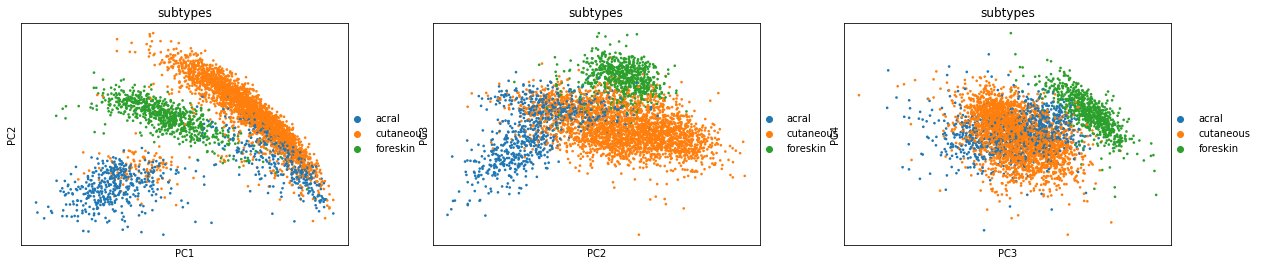

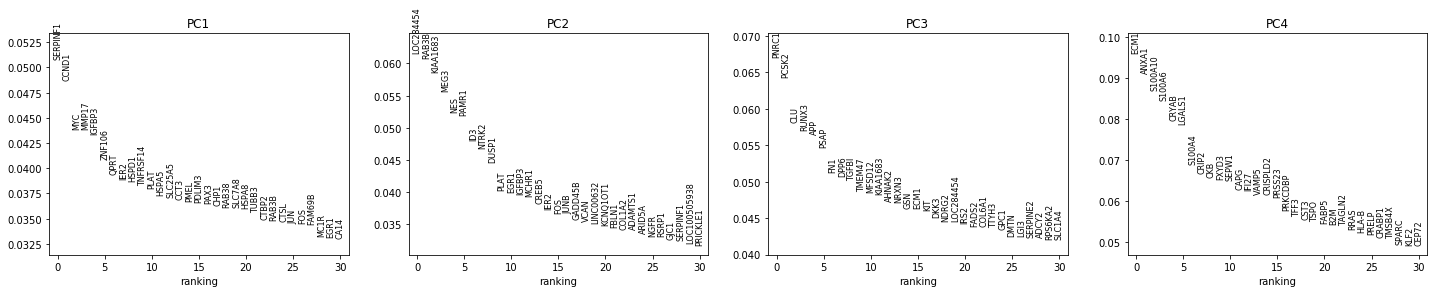

In [102]:
# supp output

input_adata = adata_subset2

label_groups = ['dev_stage','subtypes']

for key in label_groups:
    print(key)
    results_list = []
    cell_list = input_adata.obs_names
    loc_list = input_adata.obs[key].values
    for PC in range(input_adata.obsm['X_pca'].shape[1]):
        PC_list = input_adata.obsm['X_pca'][:,PC]

        pred = PC_list # must be continuous
        res = np.array(loc_list) # must be categorical
        pred = pred.reshape(-1,1)
        res = res.reshape(-1,1)

        if len(np.unique(res)) == 1:
            acc = 0
        else:
            X_train, X_test, y_train, y_test = train_test_split(pred,
                                                                res,
                                                                test_size=0.33, 
                                                                random_state=42)
            # accurcy
            clf = LogisticRegression(multi_class='auto')
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc  = f1_score(y_true = y_test, 
                            y_pred = y_pred, 
                            average = 'micro')

            results_list.append(acc)
    print(pd.DataFrame({'PC':[x+1 for x in range(len(results_list))],
                  'f1':results_list}).head(10))

    sc.pl.umap(input_adata, color=[key])
    sc.pl.pca(input_adata, components=['1,2','2,3','3,4'], color=[key])
    sc.pl.pca_loadings(input_adata, components=[1,2,3,4])
    
# extract gene names from loadings
## top10 and bottom10 genes for top10 PCs
pca_genes_df = pd.DataFrame()

for idx in range(10):
    pc_idx = idx

    pc_genes = (pd.DataFrame({'genes': input_adata.var_names.tolist(),
                              'loadings': input_adata.varm['PCs'][:,pc_idx]})
               .sort_values('loadings'))
    pc_genes['pc_idx'] = pc_idx
    pc_genes['idx'] = [x for x in range(len(pc_genes))]
    pca_genes_df = pca_genes_df.append(pc_genes.head(10))
    pca_genes_df = pca_genes_df.append(pc_genes.tail(10))
        

# spearman correlation for cancer cell line vs fet/adt/acr/cut

download: s3://daniel.le-work/MEL_project/acraldata.MvA.counts.csv to ../../data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv


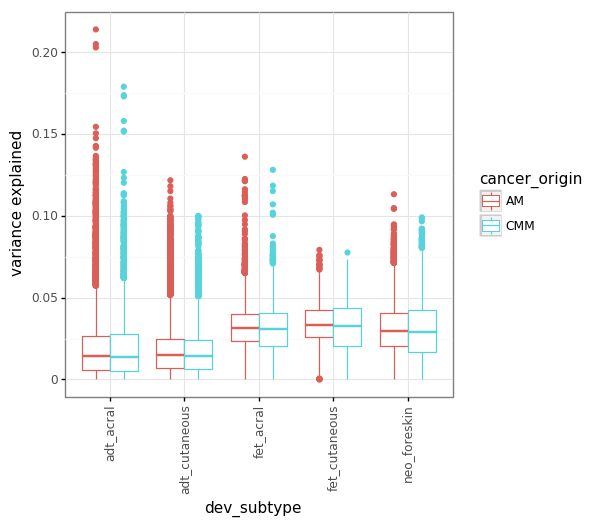

<ggplot: (-9223363261707894591)>


In [5]:
# download raw data from s3
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

# import data from s3
for file in ['acraldata.MvA.counts.csv']:
    ! aws s3 cp s3://{s3dir}/{file} {wkdir}/

# cell line counts table and filter by genes in sc data
compare_adata = adata_subset2

cell_line_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv',
                           index_col=0)
cell_line_df.columns = [x.replace('-','_') for x in cell_line_df.columns]
cell_line_df = (cell_line_df.set_index(pd.Index([x.split(' ')[0] for x in cell_line_df.index]))
                .sort_index())
cell_line_df = cell_line_df[[x in compare_adata.var_names.tolist() for x in cell_line_df.index]]
cell_line_df = cell_line_df.apply(np.log1p)
cell_line_df = cell_line_df.T

# return only genes found in both sets
cat, gene_df = prepare_dataframe(adata_subset2,
                         cell_line_df.columns.tolist(),
                         'dev_subtype')

### parallel spearman ###
import multiprocessing as mp

def parallel_paired_spearman(args):
    # reference df  MUST be single cell in order to filter on nonzero expressing genes
    
    # inputs
    ref_idx, ref_df, cross_df, nonzero_only = args

    # slice df
    ref_slice = ref_df.iloc[ref_idx,:]
    if nonzero_only == True:
        ref_slice = ref_slice[ref_slice > 0]
    else:
        pass
    ref_values = ref_slice.values
    ref_cols = ref_slice.index.tolist()
    cross_slice = cross_df.loc[:,ref_cols]
    
    stat_list = []
    pval_list = []
    for i in range(len(cross_slice)):
        cross_values = cross_slice.iloc[i,:].values
        try:
            stat, pval = stats.spearmanr(ref_values,cross_values)
        except:    
            stat = pval = np.nan
        stat_list.append(stat)
        pval_list.append(pval)

    return (stat_list, pval_list)

# create empty return arrays
stat_array = np.zeros((len(cell_line_df), len(gene_df)))
pval_array = np.zeros((len(cell_line_df), len(gene_df)))

# run parallel spearman
## create arguments list
gene_df_index = [x for x in range(len(gene_df))]
index_len = len(gene_df_index)
# index_len = 10

## run
p = mp.Pool(processes=7)

try:
    results = p.map(parallel_paired_spearman, 
                            zip(gene_df_index[:index_len], 
                                [gene_df]*index_len, 
                                [cell_line_df]*index_len,
                                [True]*index_len),
                            chunksize=100)
finally:
    p.close()
    p.join()

# recast results into arrays
for result, idx in zip(results, gene_df_index):
    stat_array[:,idx] = result[0]
    pval_array[:,idx] = result[1]

# recast array in df
stat_df = pd.DataFrame(stat_array**2)
stat_df.columns = compare_adata.obs.index.tolist()
stat_df = stat_df.set_index(cell_line_df.index)
stat_df = stat_df.T.reset_index()
stat_df = pd.melt(stat_df, id_vars='index')
stat_df = pd.merge(stat_df, 
                   compare_adata.obs.loc[:,['dev_subtype']].reset_index(),
                  'left','index')
stat_df['cancer_origin'] = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in stat_df['variable']]

# variance explained distributions
plotnine.options.figure_size = (5,5)
print(ggplot(stat_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('dev_subtype','value', color = 'cancer_origin'))
      + labs(y='variance explained')
     )


# compare fetal to cell line expression

100%|██████████| 6806/6806 [00:05<00:00, 1247.36it/s]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


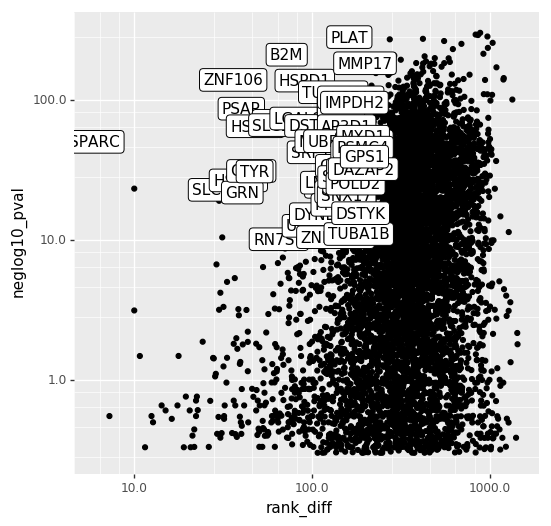

<ggplot: (-9223363261707902015)>


,gene,rank_diff,stat,pval,nonzero_count,neglog10_pval,label
277,CCND1,103.0,150136.5,0.000000e+00,516,inf,True
619,PLAT,162.0,143106.5,5.434189e-282,537,281.264865,True
151,B2M,72.0,137278.5,3.015276e-211,542,210.520673,True
936,MMP17,198.5,228555.5,1.211627e-183,533,182.916631,True
52,ZNF106,36.0,278540.5,8.866392e-140,544,139.052253,True
236,HSPD1,91.0,305141.0,2.973231e-138,534,137.526771,True
424,TUBB4B,131.5,370542.5,2.595790e-114,503,113.585730,True
637,SLC7A8,165.0,347451.0,3.940019e-105,542,104.404502,True
701,IMPDH2,173.0,407634.5,1.979676e-96,479,95.703406,True
502,CST3,145.5,375619.5,6.657653e-91,538,90.176679,True


In [6]:
from collections import defaultdict

def parallel_mwu(gene_val):    
    # compute
    global adt_cells
    global fet_cells
    
    try:
        stat, pval = stats.mannwhitneyu(adt_cells[gene_val].values,
                                        fet_cells[gene_val].values
                                       )
    except:
        stat = np.nan
        pval = np.nan
    return (stat, pval)

#return only genes found in both cancer cell lines and fetal single cells
cat, gene_df_fet = prepare_dataframe(adata_subset2[adata_subset2.obs.dev_stage == 'fet'],
                         cell_line_df.columns.tolist(),
                         'dev_stage')

# compute rank difference between single cells and cancer cell lines
## store rank difference in dictionary of lists
rank_diff_dict = defaultdict(list)

## iterate over all pairs
for sc_row in tqdm.tqdm(range(len(gene_df_fet))):     
    for cl_row in range(len(cell_line_df)): 
        # filter by nonzero expressing genes in single cell
        keep_idx = gene_df_fet.iloc[sc_row,:].values > 0
        gene_vals = np.array(gene_df_fet.columns)[keep_idx]
        sc_vals = stats.rankdata(gene_df_fet.iloc[sc_row,:].values[keep_idx])
        bulk_vals = stats.rankdata(cell_line_df.iloc[cl_row,:].values[keep_idx])
        rank_diff_vals = abs(sc_vals - bulk_vals)
        
        # update dictionary with observed genes and ranks
        for gene, rank in zip(gene_vals.tolist(), rank_diff_vals.tolist()):
            rank_diff_dict[gene].append(rank)

# compute median difference between single cells and cancer cell lines
for key,value in tqdm.tqdm(rank_diff_dict.items()):
    rank_diff_dict[key] = np.median(value)   

genes = [x[0] for x in sorted(rank_diff_dict.items(), key=lambda k_v: k_v[1], reverse=False)]
rank_diffs = [x[1] for x in sorted(rank_diff_dict.items(), key=lambda k_v: k_v[1], reverse=False)]
    
# identify genes differentially expressed between fetal vs adult single cells
cat, gene_df = prepare_dataframe(adata_subset2,
                         cell_line_df.columns.tolist(),
                         'dev_subtype')
adt_cells = gene_df[[x.startswith('adt') for x in gene_df.index.astype(str)]]
fet_cells = gene_df[[x.startswith('fet') for x in gene_df.index.astype(str)]]

p = mp.Pool(processes=7)

try:
    mwu_tuples = p.map(parallel_mwu, 
                            genes, 
                            chunksize=100)
finally:
    p.close()
    p.join()

stat_list = [x[0] for x in mwu_tuples]
pval_list = [x[1] for x in mwu_tuples]

# compile results in df
rank_df = pd.merge(pd.DataFrame({'gene':genes,
                                 'rank_diff':rank_diffs,
                                 'stat':stat_list,
                                 'pval':pval_list
                                }),
                   pd.DataFrame({'nonzero_count':gene_df_fet.astype(bool).sum(axis=0)}).reset_index().rename(columns = {'index':'gene'}),
                   'left','gene')

# Filter on genes with user-defined thresholds
rank_df['neglog10_pval'] = -np.log10(rank_df.pval.values)
rank_df['label'] = [x < 200 and y > 10 and z > 100 for x,y,z in zip(rank_df.rank_diff.values, 
                                                      rank_df.neglog10_pval.values,
                                                      rank_df.nonzero_count.values
                                                     )]

plotnine.options.figure_size = (6,6)
print(ggplot(rank_df)
     + geom_point(rank_df, aes('rank_diff','neglog10_pval'))
     + geom_label(rank_df[rank_df.label == True], aes('rank_diff','neglog10_pval', label = 'gene'))
     + scale_x_log10()
     + scale_y_log10()
     )

rank_df[rank_df.label == True].sort_values('pval', ascending = True).head(10)

In [ ]:
gene = 'CST3'
seed = 200
plot_df = pd.DataFrame({'sc': gene_df_fet.sample(1, random_state=seed).values.flatten(),
                        'bulk': cell_line_df.sample(1, random_state=seed).values.flatten(),
                        'gene':gene_df_fet.columns.tolist()})
plot_df = plot_df[plot_df.sc > 0]
plot_df['pass'] = [x == gene for x in plot_df.gene]

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
     + theme_bw() 
     + geom_bin2d(aes('bulk','sc',alpha = 'pass'))
#      + scale_fill_cmap('magma_r')
     + scale_alpha_discrete(range = (0.3, 1))
     )

plot_df = pd.DataFrame()
scaled_cell_line_df = (cell_line_df - np.min(cell_line_df)) / (np.max(cell_line_df) - np.min(cell_line_df))
scaled_gene_df = (gene_df - np.min(gene_df)) / (np.max(gene_df) - np.min(gene_df))
for origin in [scaled_cell_line_df, scaled_gene_df]:
    if origin is scaled_cell_line_df:
        origin_val = 'bulk'
        dev_val = 'cancer'
        subtype_val = cell_line_df.index.tolist()
        subtype_val = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in subtype_val]
    else:
        origin_val = 'sc'
        dev_val = adata_subset2.obs.dev_stage.tolist()
        subtype_val = adata_subset2.obs.subtypes.tolist()

    tmp = pd.DataFrame({gene:origin.loc[:,gene].values})
    tmp['origin'] = origin_val
    tmp['dev_stage'] = dev_val
    tmp['subtype'] = subtype_val
    plot_df = plot_df.append(tmp)

plot_df['dev_subtype'] = [f'{x}_{y}' for x,y in zip(plot_df.dev_stage, plot_df.subtype)]
plot_df['dev_subtype'] = plot_df['dev_subtype'].astype(str).astype(CategoricalDtype(['cancer_CMM',
                                                                                     'cancer_AM',
                                                                            'fet_cutaneous',
                                                                            'fet_acral',
                                                                            'neo_foreskin',
                                                                            'adt_cutaneous',
                                                                            'adt_acral'], 
                                                                            ordered = True))

print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('dev_subtype',gene))
      + labs(y = 'min-max normalized log expression')
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

sc.pl.umap(full_adata, color = [gene], cmap = 'magma_r')


# Significant difference AM/CMM AND sc ACR/CUT


In [7]:
# cell line mwu
cell_line_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv',
                           index_col=0)
cell_line_df.columns = [x.replace('-','_') for x in cell_line_df.columns]
cell_line_df = (cell_line_df.set_index(pd.Index([x.split(' ')[0] for x in cell_line_df.index]))
                .sort_index())
cell_line_df = cell_line_df[[x in compare_adata.var_names.tolist() for x in cell_line_df.index]]
cell_line_df = cell_line_df.apply(np.log1p)
cell_line_df = cell_line_df.T
cell_line_df['cancer_origin'] = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in cell_line_df.index]
CMM_lines = cell_line_df[cell_line_df.cancer_origin == 'CMM']
AM_lines = cell_line_df[cell_line_df.cancer_origin == 'AM']

stat_list = []
pval_list = []
gene_list = []
for gene in tqdm.tqdm(cell_line_df.columns.tolist()[:-1]):
    try:
        stat, pval = stats.mannwhitneyu(AM_lines.loc[:,gene], CMM_lines.loc[:,gene], alternative = 'greater')
        stat_list.append(stat)
        pval_list.append(pval)
        gene_list.append(gene)
    except:
        pass
    
cell_line_mwu = pd.DataFrame({'stat':stat_list,
                              'pval':pval_list,
                              'gene':gene_list
                             })
cell_line_mwu = cell_line_mwu.sort_values('stat', ascending = False)
cell_line_mwu['cl_rank'] = [x for x in range(len(cell_line_mwu))]

# single cell mwu
cut_cells = gene_df[gene_df.index == 'fet_cutaneous']
acr_cells = gene_df[gene_df.index == 'fet_acral']

stat_list = []
pval_list = []
gene_list = []
for gene in tqdm.tqdm(gene_df.columns.tolist()):
    try:
        stat, pval = stats.mannwhitneyu(acr_cells.loc[:,gene], cut_cells.loc[:,gene], alternative = 'greater')
        stat_list.append(stat)
        pval_list.append(pval)
        gene_list.append(gene)
    except:
        pass
    
sc_mwu = pd.DataFrame({'stat':stat_list,
                              'pval':pval_list,
                              'gene':gene_list
                             })
sc_mwu = sc_mwu.sort_values('stat', ascending = False)
sc_mwu['sc_rank'] = [x for x in range(len(sc_mwu))]

# inner join and sort
inner_mwu = pd.merge(sc_mwu.drop(['stat','pval'], axis = 1),
                     cell_line_mwu.drop(['stat','pval'], axis = 1),
                     'inner',
                     'gene')
inner_mwu = inner_mwu.loc[inner_mwu.gene != 'ALG1L9P']
inner_mwu['rank_sum']  = inner_mwu.sc_rank + inner_mwu.cl_rank
inner_mwu.sort_values('rank_sum').head(10)


100%|██████████| 7213/7213 [00:19<00:00, 364.36it/s]


,gene,sc_rank,cl_rank,rank_sum
24,PLTP,22,7,29
66,MXD4,64,4,68
172,LAMB2,170,26,196
205,CTSF,203,39,242
250,CLEC11A,248,27,275
124,QPRT,122,179,301
175,FCGRT,173,142,315
321,AEBP1,319,11,330
151,PRELP,149,207,356
416,GS1-124K5.11,414,9,423


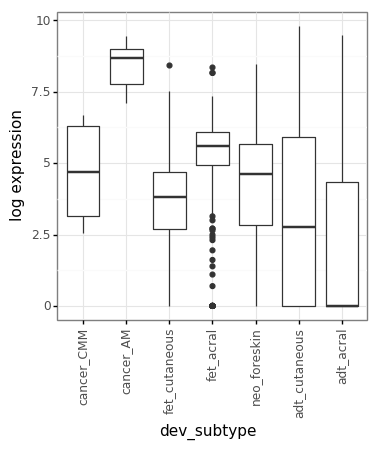

<ggplot: (-9223363261715228521)>
querying 1-1...done.
Finished.
0:  PLTP 
 The protein encoded by this gene is one of at least two lipid transfer proteins found in human plasma. The encoded protein transfers phospholipids from triglyceride-rich lipoproteins to high density lipoprotein (HDL). In addition to regulating the size of HDL particles, this protein may be involved in cholesterol metabolism. At least two transcript variants encoding different isoforms have been found for this gene. [provided by RefSeq, Jul 2008].


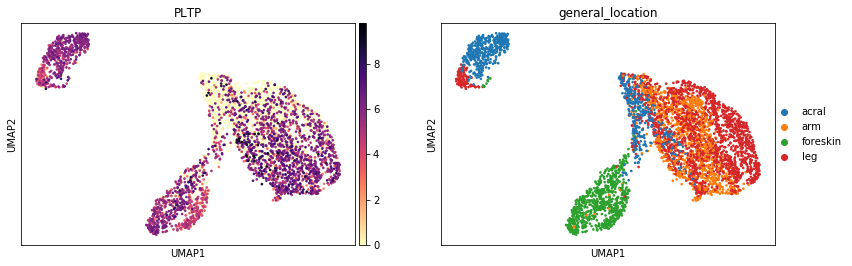

In [8]:
gene = 'PLTP'

plot_df = pd.DataFrame()
for origin in [cell_line_df, gene_df]:
    if origin is cell_line_df:
        origin_val = 'bulk'
        dev_val = 'cancer'
        subtype_val = cell_line_df.index.tolist()
        subtype_val = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in subtype_val]
    else:
        origin_val = 'sc'
        dev_val = adata_subset2.obs.dev_stage.tolist()
        subtype_val = adata_subset2.obs.subtypes.tolist()

    tmp = pd.DataFrame({gene:origin.loc[:,gene].values})
    tmp['origin'] = origin_val
    tmp['dev_stage'] = dev_val
    tmp['subtype'] = subtype_val
    plot_df = plot_df.append(tmp)

plot_df['dev_subtype'] = [f'{x}_{y}' for x,y in zip(plot_df.dev_stage, plot_df.subtype)]
plot_df['dev_subtype'] = plot_df['dev_subtype'].astype(str).astype(CategoricalDtype(['cancer_CMM',
                                                                                     'cancer_AM',
                                                                            'fet_cutaneous',
                                                                            'fet_acral',
                                                                            'neo_foreskin',
                                                                            'adt_cutaneous',
                                                                            'adt_acral'], 
                                                                            ordered = True))
plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('dev_subtype',gene))
      + labs(y = 'log expression')
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

sc.pl.umap(adata_subset2, color = [gene,'general_location'], cmap = 'magma_r')

# Correlate to sc melanoma data

In [9]:
## correlate with cancer manuscript raw data: http://science.sciencemag.org/content/352/6282/189
# accession numbers GSE72056 and GSE77940
# contains tumor cell counts table: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056
sc_mel_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/cancer_ext_data/GSE72056_melanoma_single_cell_revised_v2.txt',
           sep = '\t')

sc_mel_counts = (sc_mel_df.iloc[3:,:]
                 .rename(columns = {'Cell':'gene'})
                 .set_index('gene')
                 .T
                )

# filter by adata gene list and remove duplicate genes
gene_count = pd.DataFrame({'gene':sc_mel_counts.columns})['gene'].value_counts()
sc_mel_counts = sc_mel_counts.drop(gene_count[gene_count > 1].index.tolist(), axis = 1)
sc_mel_counts = sc_mel_counts.loc[:,[x for x in adata_subset2.var_names.tolist() if x in sc_mel_counts.columns.tolist()]]

# meta key
## malignant(1=no,2=yes,0=unresolved)
## non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)
sc_mel_meta = (sc_mel_df
               .iloc[:3,:]
               .set_index('Cell')
               .T
               .rename(columns = {'malignant(1=no,2=yes,0=unresolved)':'malignant',
                                 'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)':'celltype'
                                 })
               .astype(int)
              )

# filter by meta data to only mel cells of interest
mel_cell_id = [53,58,60,72,74,78,79,80,81,84,88,89,94]
filtered_cell_names = sc_mel_meta[[x == 2 and y in mel_cell_id and z == 0 for x,y,z in zip(sc_mel_meta.malignant, 
                                                        sc_mel_meta.tumor, 
                                                        sc_mel_meta.celltype)
            ]
           ].index.tolist()

sc_mel_counts = sc_mel_counts[[x in filtered_cell_names for x in sc_mel_counts.index]]

# return only genes found in both sets
cat, gene_df = prepare_dataframe(adata_subset2,
                         sc_mel_counts.columns.tolist(),
                         'dev_subtype')
    
# create empty return arrays
stat_array = np.zeros((len(sc_mel_counts), len(gene_df)))
pval_array = np.zeros((len(sc_mel_counts), len(gene_df)))

# run parallel spearman
# create arguments list
gene_df_index = [x for x in range(len(gene_df))]
index_len = len(gene_df_index)

## run
p = mp.Pool(processes=7)

try:
    results = p.map(parallel_paired_spearman, 
                            zip(gene_df_index[:index_len], 
                                [gene_df]*index_len, 
                                [sc_mel_counts]*index_len,
                                [True]*index_len),
                            chunksize=100)
finally:
    p.close()
    p.join()

# recast results into arrays
for result, idx in zip(results, gene_df_index):
    stat_array[:,idx] = result[0]
    pval_array[:,idx] = result[1]

# recast array in df
stat_df = pd.DataFrame(stat_array**2)
stat_df.columns = adata_subset2.obs.index.tolist()
stat_df = stat_df.set_index(sc_mel_counts.index)
stat_df = stat_df.T.reset_index()
stat_df = pd.melt(stat_df, id_vars='index')
stat_df = pd.merge(stat_df, 
                   adata_subset2.obs.loc[:,['dev_subtype']].reset_index(),
                  'left','index')

# variance explained distributions
plotnine.options.figure_size = (5,5)
print(ggplot(stat_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('dev_subtype','value'))
      + labs(y='variance explained')
     )

In [11]:
# correlate primary cell line expression with primary tumor expression


,index,variable,value,dev_subtype
0,J15_B003063,Cy81_FNA_CD45_B01_S301_comb,0.011491,adt_cutaneous
1,G22_B003063,Cy81_FNA_CD45_B01_S301_comb,0.000165,adt_cutaneous
2,J12_B003063,Cy81_FNA_CD45_B01_S301_comb,0.000114,adt_cutaneous
3,J17_B003063,Cy81_FNA_CD45_B01_S301_comb,0.014174,adt_cutaneous
4,H8_B003063,Cy81_FNA_CD45_B01_S301_comb,0.003220,adt_cutaneous


# KRT n_genes analysis


In [ ]:
sc.pl.umap(adata_subset1_KRT, color = ['n_genes', 'age', 'n_counts', 'KRT10'], cmap = 'nipy_spectral', ncols = 2)
krt_ngenes = adata_subset1_KRT.obs.loc[:,['n_genes','age_group']].reset_index()
cat, krt_genes = prepare_dataframe(adata_subset1_KRT, adata_subset1_KRT.var_names, 'age_bin')
krt_genes = krt_genes.reset_index()
krt_df = pd.concat([krt_genes, krt_ngenes], axis = 1)


In [ ]:
print(ggplot(krt_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('age_bin','n_genes'))
     )

print(ggplot(krt_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes('age_group','n_genes'))
     )

# cellphone db testing

In [46]:
import mygene
mg = mygene.MyGeneInfo()

# filter by age (adt vs fet)
input_adata = full_adata[[x not in ['FET_12WK','NEO'] for x in full_adata.obs.age_group]]

# filter by general_location (acral vs. cut[arm/leg])
input_adata = input_adata[[x not in ['acral','foreskin'] for x in input_adata.obs.general_location]]


# pull ensembl names from gene symbols
# gene_symbols = input_adata.var_names.tolist()
# results = mg.querymany(gene_symbols, scopes='symbol', species='human', fields = 'ensembl')

# genes_used = []
# ensembl_list = []
# for idx, gene in enumerate(gene_symbols):
#     try:
#         ensembl_name = results[idx]['ensembl']['gene']
#         ensembl_list.append(ensembl_name)
#         genes_used.append(gene)
#     except:
#         pass
    
# name_conv_df = pd.DataFrame({'gene':genes_used,
#                              'ensembl':ensembl_list})

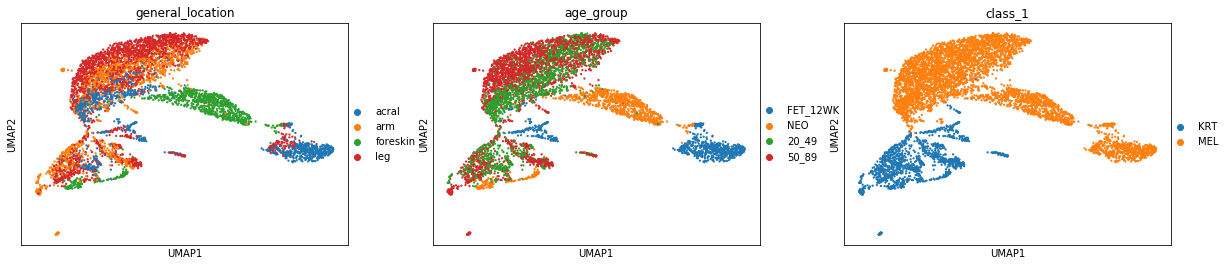

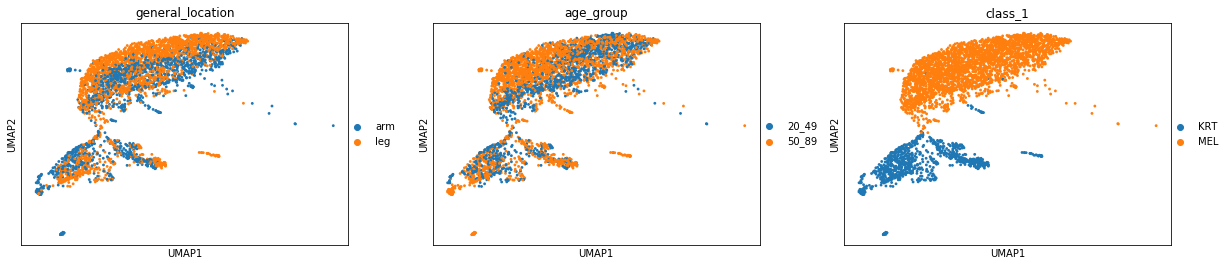

In [47]:
# sanity check
sc.pl.umap(full_adata, color = ['general_location', 'age_group','class_1'])
sc.pl.umap(input_adata, color = ['general_location', 'age_group','class_1'])


In [48]:
# create metadata
file_prefix = 'adtcut'

meta_data_df = input_adata.obs.loc[:,['age_group','class_1']]
rename_dict = {'20_49':'ADT',
               '50_89':'ADT',
               'FET_12WK':'FET',
               'NEO':'NEO'
              }
meta_data_df['metalabel'] =  ['{}_{}'.format(rename_dict[x],y) for x,y in zip(meta_data_df['age_group'], meta_data_df['class_1'])]
meta_data_df = meta_data_df.drop(['age_group','class_1'], axis=1).reset_index().rename(columns = {'index':'Cell',
                                                                                                  'metalabel':'cell_type'})
meta_data_df.to_csv(f'/home/ubuntu/data/cellphonedb/{file_prefix}_metadata.txt', index=False, sep='\t')

# merge with expression data
cat, expdf = prepare_dataframe(input_adata, genes_used, 'age_bin')
expdf = expdf.set_index(input_adata.obs.index)
expdf = expdf.T.reset_index().rename(columns = {'index':'gene'})
expdf = pd.merge(expdf, name_conv_df, 'left','gene').drop('gene', axis=1).set_index('ensembl')
expdf = expdf.reset_index().rename(columns = {'ensembl':'Gene'})
expdf.to_csv(f'/home/ubuntu/data/cellphonedb/{file_prefix}_counts.txt', index=False, sep='\t')

# in shell: run cellphoneDB package
# rename dir

In [70]:
# read in cellphone db results
dir_name1 = 'fetacral_out'
target1 = ['FET_MEL_FET_MEL']
id1 = 'adtacral'
dir_name2 = 'fetcut_out'
target2 = ['FET_MEL_FET_MEL']
id2 = 'adtcut'

results1 = pd.read_csv(f'/home/ubuntu/data/cellphonedb/{dir_name1}/significant_means.txt', sep='\t')
pairs1 = pd.DataFrame()
for target in target1:
    tmp = results1.loc[:,['interacting_pair'] + [target]].dropna().drop(target, axis = 1)
    pairs1 = pairs1.append(tmp)
pairs1['id'] = id1

results2 = pd.read_csv(f'/home/ubuntu/data/cellphonedb/{dir_name2}/significant_means.txt', sep='\t')
pairs2 = pd.DataFrame()
for target in target2:
    tmp = results2.loc[:,['interacting_pair'] + [target]].dropna().drop(target, axis = 1)
    pairs2 = pairs2.append(tmp)
pairs2['id'] = id2

all_pairs = pairs1.append(pairs2)
all_pairs = all_pairs.drop_duplicates()
all_pairs[[x in all_pairs
           .interacting_pair
           .value_counts()
           .index[all_pairs
                  .interacting_pair
                  .value_counts()==1]
           .tolist() for x in all_pairs
           .interacting_pair]]


,interacting_pair,id
0,EFNA4_EPHA3,adtacral
17,a2Bb3 complex_VTN,adtacral
21,CD40LG_a2Bb3 complex,adtacral
24,HBEGF_EGFR,adtacral


acral


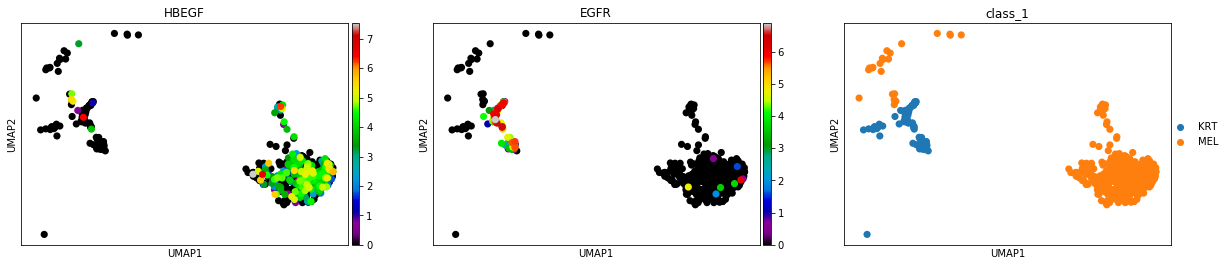

cutaneous


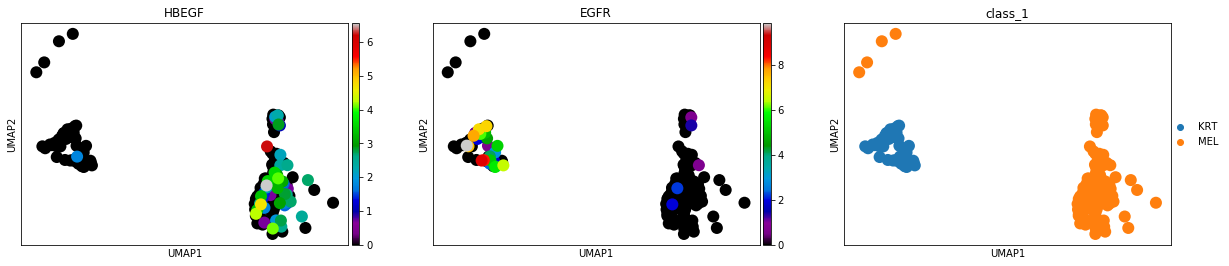

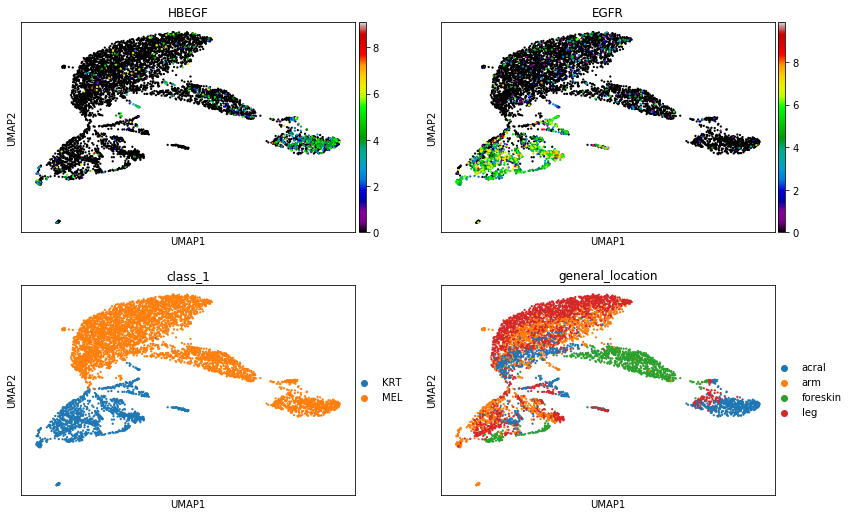

querying 1-2...done.
Finished.
0:  HBEGF 
 N/A
1:  EGFR 
 The protein encoded by this gene is a transmembrane glycoprotein that is a member of the protein kinase superfamily. This protein is a receptor for members of the epidermal growth factor family. EGFR is a cell surface protein that binds to epidermal growth factor. Binding of the protein to a ligand induces receptor dimerization and tyrosine autophosphorylation and leads to cell proliferation. Mutations in this gene are associated with lung cancer. [provided by RefSeq, Jun 2016].


In [73]:
gene_pair = 'HBEGF_EGFR'.split('_')

print('acral')
input_adata = full_adata[[x in ['FET_12WK'] for x in full_adata.obs.age_group]]
input_adata = input_adata[[x in ['acral'] for x in input_adata.obs.general_location]]
sc.pl.umap(input_adata, 
           color = gene_pair + ['class_1'], 
           cmap = 'nipy_spectral')

print('cutaneous')
input_adata = full_adata[[x in ['FET_12WK'] for x in full_adata.obs.age_group]]
input_adata = input_adata[[x not in ['acral','foreskin'] for x in input_adata.obs.general_location]]
sc.pl.umap(input_adata, 
           color = gene_pair + ['class_1'], 
           cmap = 'nipy_spectral')

sc.pl.umap(full_adata, 
           color = gene_pair + ['class_1','general_location'], 
           cmap = 'nipy_spectral',
           ncols = 2
          )

out = symbol2field(gene_pair)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]



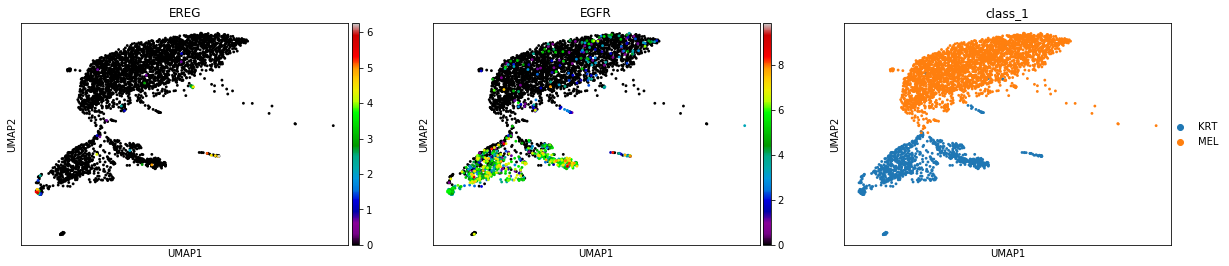

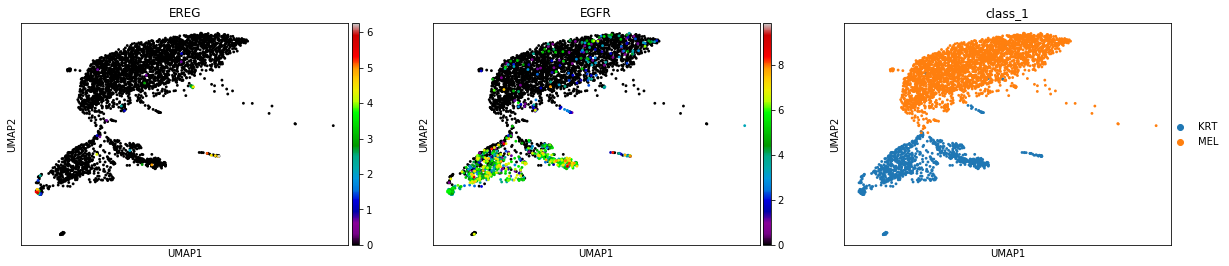

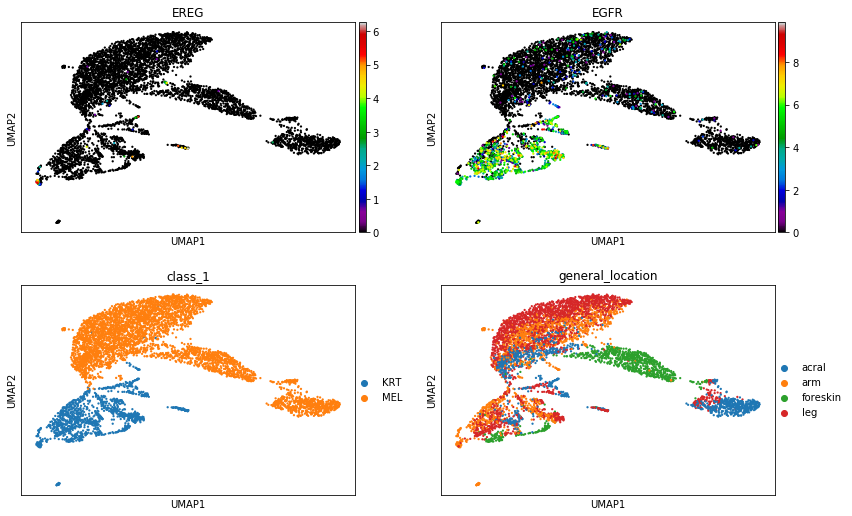

querying 1-2...done.
Finished.
0:  EREG 
 This gene encodes a secreted peptide hormone and member of the epidermal growth factor (EGF) family of proteins. The encoded protein is a ligand of the epidermal growth factor receptor (EGFR) and the structurally related erb-b2 receptor tyrosine kinase 4 (ERBB4). The encoded protein may be involved in a wide range of biological processes including inflammation, wound healing, oocyte maturation, and cell proliferation. Additionally, the encoded protein may promote the progression of cancers of various human tissues. [provided by RefSeq, Jul 2015].
1:  EGFR 
 The protein encoded by this gene is a transmembrane glycoprotein that is a member of the protein kinase superfamily. This protein is a receptor for members of the epidermal growth factor family. EGFR is a cell surface protein that binds to epidermal growth factor. Binding of the protein to a ligand induces receptor dimerization and tyrosine autophosphorylation and leads to cell proliferation

In [68]:
# adt cut vs acral

gene_pair = 'EREG_EGFR'.split('_')

# adt cutaneous
input_adata = full_adata[[x not in ['FET_12WK','NEO'] for x in full_adata.obs.age_group]]
input_adata = input_adata[[x not in ['acral','foreskin'] for x in input_adata.obs.general_location]]
sc.pl.umap(input_adata, 
           color = gene_pair + ['class_1'], 
           cmap = 'nipy_spectral')

# adt acral
input_adata = full_adata[[x not in ['FET_12WK','NEO'] for x in full_adata.obs.age_group]]
input_adata = input_adata[[x not in ['acral'] for x in input_adata.obs.general_location]]
sc.pl.umap(input_adata, 
           color = gene_pair + ['class_1'], 
           cmap = 'nipy_spectral')

sc.pl.umap(full_adata, 
           color = gene_pair + ['class_1','general_location'], 
           cmap = 'nipy_spectral',
           ncols = 2
          )

out = symbol2field(gene_pair)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]



# acral analysis

In [100]:
# ### Need to classify cell type to disambigueate mixed populations in general location


# %%capture

# # fet acral and adult signalling?

# ###############################################
# ###############################################
# # Classify acral vs. cutaneous vs. foreskin cells
# # This chunk updates input adata
# ###############################################
# ###############################################

# patient2feature = {'12WKM01':'0',
#                    'A1038LM':'1'}

# input_adata = adata_subset2

# rank_groupby = 'louvain'
# rank_ngenes = 20

# ###############################################

# ranks_dict = {}
# for patientOI, value in patient2feature.items():
#     exec(f'global adata_{patientOI}')
#     input_adata = adata_subset2
#     patients = list(set(input_adata.obs.patient))
#     type_dict = {'in':[patientOI],
#                  'out':[x for x in patients if x != patientOI]}

#     classify_type(raw_adata, input_adata, 'patient', type_dict, 'class_3')

#     feature_dict = {'class_3':['in']}
#     adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
#     adata_subset3 = process_adata(adata_subset3)
#     pca_adata(adata_subset3, num_pcs=30)
#     umap_adata(adata_subset3, res=0.2)
#     sc.pl.umap(adata_subset3, color=['louvain','general_location'])
    
#     exec(f'adata_{patientOI} = input_adata = adata_subset3')
#     ranks_df = simple_rank (input_adata, groupby=rank_groupby, n_genes=rank_ngenes)
#     ranks_df['patient'] = patientOI
#     ranks_dict[patientOI] = ranks_df

# # extract cell id from individual patients with acral
# # rely on louvain clustering to annotate cell type

# acral_cells_list = []
# for key,value in patient2feature.items():
#     acral_slice = eval(f'adata_{key}.obs.reset_index().loc[:,["index","louvain"]]')
#     acral_slice = acral_slice[acral_slice.louvain == patient2feature[key]]
#     acral_cells = acral_slice['index'].values.tolist()
#     acral_cells_list= acral_cells_list + acral_cells

# # create cell type labels: cut, fsk, acr
# adata_subset2.obs['cell_type'] = ['fsk' if x == 'foreskin' else 'cut' for x in adata_subset2.obs.general_location]
# adata_subset2.obs['cell_type'] = ['acr' if x in acral_cells_list else y for x,y in zip(adata_subset2.obs.index,
#                                                                                        adata_subset2.obs.cell_type)]


In [84]:
# To isolate acral-specific expression, the union of age-independent genes 
#between acral and cutaneous gene sets are tested for differential expression

input_adata = adata_subset2
input_adata.obs['age_label'] = ['FET' if x == 'FET_12WK' else 'NOT_FET' for x in input_adata.obs['age_group']]
input_adata.obs['age_label'] = input_adata.obs['age_label'].astype(str).astype(CategoricalDtype(['FET','NOT_FET']))
input_adata = input_adata[input_adata.obs.general_location != 'foreskin']
cell_groups = 'cell_type' 

# Which acral-specific genes are NOT significantly different between FET and ADT?
alpha = 0.001
stat_list = []
pval_list = []
gene_list = []
cell_list = []

for cell_type_val in ['acr', 'cut']:
    slice_df = input_adata[[x == cell_type_val for x in input_adata.obs[cell_groups]]]
    cat, prep_slice = prepare_dataframe(slice_df,
                                     var_names = pc_genes,
                                     groupby = 'age_label')
    prep_slice = prep_slice.reset_index()
    fet_splice = prep_slice[[x == 'FET' for x in prep_slice.age_label]]
    nfet_splice = prep_slice[[x == 'NOT_FET' for x in prep_slice.age_label]]

    for gene in pc_genes:
        fet_vec = fet_splice[gene].values
        nfet_vec = nfet_splice[gene].values
        stat, pval = stats.mannwhitneyu(fet_vec, nfet_vec)
        stat_list.append(stat)
        pval_list.append(pval)
        gene_list.append(gene)
        cell_list.append(cell_type_val)

test_cell_group = (pd.DataFrame({'stat':stat_list,
                             'pval':pval_list,
                             'gene':gene_list,
                             'cell_type':cell_list})
              .sort_values('pval', ascending = False)
              )
adj_alpha = alpha / len(test_cell_group)
test_cell_group['pass'] = [x < adj_alpha for x in test_cell_group.pval]

testable_genes = []
for cell_type_val in ['acr', 'cut']: 
    print(f'Rank sum test: {cell_type_val}-specific expression between age groups')
    display(test_cell_group[[x == cell_type_val and y == False for x,y in zip(test_cell_group.cell_type, 
                                                                              test_cell_group['pass'])]])

    geneslist = (test_cell_group[[x == cell_type_val and y == False for x,y in zip(test_cell_group.cell_type, 
                                                                    test_cell_group['pass'])]]
                 .gene
                 .values
                 .tolist()
                )
    cat, input_slice = prepare_dataframe(input_adata[input_adata.obs.cell_type == cell_type_val],
                                         var_names = test_cell_group[test_cell_group.cell_type == cell_type_val].gene.tolist(),
                                         groupby = 'age_label')
    input_slice = input_slice.reset_index()
    plot_df = pd.melt(input_slice, id_vars=['age_label']).dropna()
    plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(test_cell_group[test_cell_group.cell_type == cell_type_val].gene.tolist(), ordered = True))
    print(ggplot(plot_df)
     +theme_bw()
     +theme(axis_text_x = element_text(angle = 90))
     +geom_boxplot(aes('variable', 'value', fill = 'age_label'))
     +labs(x='', y = 'log exp')
    )
    testable_genes = testable_genes + geneslist

# Of the identified genes, which exhibit a significant difference between acral and cutaneous cell type

testable_df = pd.DataFrame({'gene':testable_genes})
testable_df = testable_df['gene'].value_counts().reset_index()
testable_genes = testable_df[testable_df.gene > 1]['index'].values.tolist()

stat_list = []
pval_list = []
gene_list = []
cat, prep_slice = prepare_dataframe(input_adata,
                                     var_names = list(set(testable_genes)),
                                     groupby = cell_groups)
prep_slice = prep_slice.reset_index()
prep_slice['age_label'] = input_adata.obs.age_label.values
cut_input = prep_slice[[x == 'cut' for x in prep_slice[cell_groups]]]
acr_input = prep_slice[[x == 'acr' for x in prep_slice[cell_groups]]]

for gene in list(set(testable_genes)):
    cut_vec = cut_input[gene].values
    acr_vec = acr_input[gene].values
    stat, pval = stats.mannwhitneyu(acr_vec, cut_vec)
    stat_list.append(stat)
    pval_list.append(pval)
    gene_list.append(gene)
    cell_list.append(cell_type_val)

diff_test = (pd.DataFrame({'stat':stat_list,
                             'pval':pval_list,
                             'gene':gene_list})
              .sort_values('pval', ascending = True)
              )
adj_alpha = alpha / ((2 * len(pc_genes)) + len(testable_genes))
diff_test['pass'] = [x < adj_alpha for x in diff_test.pval]
print('Rank sum test: Differential expression between age groups')
display(diff_test)

plot_df = pd.melt(prep_slice, id_vars = [cell_groups, 'age_label'])
print(ggplot(plot_df)
 +theme_bw()
 +theme(axis_text_x = element_text(angle = 90))
 +geom_boxplot(aes('variable', 'value', fill = 'age_label'))
 +facet_wrap('~cell_type', scales = 'free')
 +labs(x='', y = 'log exp')
)
        
        

{'adt', 'fet', 'neo'}

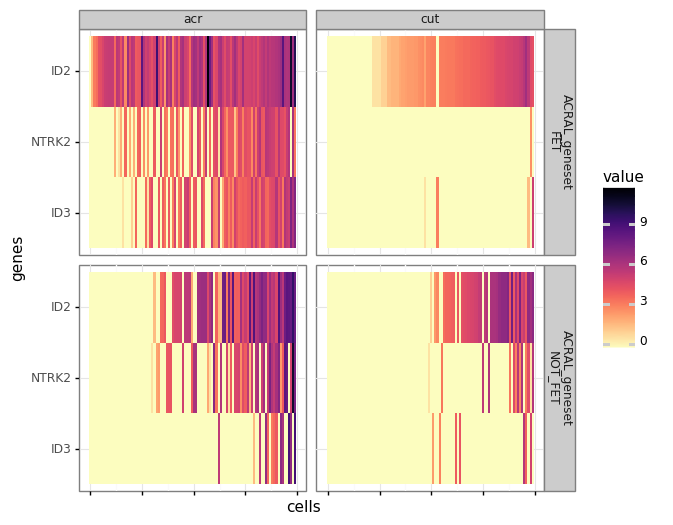

<ggplot: (8726328560886)>


In [80]:
### (Fet vs non-fet age) by (acral vs leg location)

# heat map
input_adata = adata_subset2
input_adata.obs['age_label'] = ['FET' if x == 'FET_12WK' else 'NOT_FET' for x in input_adata.obs['age_group']]
input_adata.obs['age_label'] = input_adata.obs['age_label'].astype(str).astype(CategoricalDtype(['FET','NOT_FET']))
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
genes = ['NTRK2', 'ID2', 'ID3'] # from wilcoxon / t-test DE genes lists
groupby_var = 'acr'
cell_groups = 'cell_type'
pcOIs = [1]
pc_genes = (pca_genes_df[[x == groupby_var and y in pcOIs for x,y in zip(pca_genes_df['groupby'], 
                                                                         pca_genes_df['pc_idx'])]]
                 .genes
                 .values
                 .tolist())
genelist_df = pd.DataFrame({'genes':genes+pc_genes})
genelist = genelist_df.drop_duplicates().genes.values.tolist()
return_df = pd.DataFrame()

for label in ['acr','cut']: # cell type
    for group in ['FET','NOT_FET']:
        slice_df = input_adata[[x == label and y == group for x,y in zip(input_adata.obs[cell_groups], 
                                                                         input_adata.obs.age_label)]]
        cells2keep = slice_df.obs.sample(100).index.tolist()
        slice_df = slice_df[[x in cells2keep for x in slice_df.obs.index.tolist()]]
        cat, genesOI_df = prepare_dataframe(slice_df,
                                            var_names = genelist,
                                            groupby='age_label')  
        genesOI_df = genesOI_df.reset_index() # recover groupby label
        genesOI_df[cell_groups] = label
        genesOI_df['row_mean'] = genesOI_df.mean(axis = 1)
        genesOI_df = genesOI_df.sort_values('row_mean')
        genesOI_df['index'] = [x for x in range(len(genesOI_df))]
        return_df = return_df.append(genesOI_df.drop('row_mean', axis = 1))

plot_df = pd.melt(return_df, id_vars=['index','age_label',cell_groups])
target_gene_order = (plot_df[plot_df[cell_groups] == groupby_var]
                     .groupby('variable')
                     .mean()
                     .sort_values('value')
                     .index
                     .tolist())
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(target_gene_order, ordered=True))
plot_df['group'] = ['MEL_geneset' if x in canonical_genes else 'ACRAL_geneset' for x in plot_df.variable]

plotnine.options.figure_size = (6,6)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.1,
            axis_text_x = element_blank())
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid(f'age_label+group~{cell_groups}', scales='free')
     +labs(x='cells',y='genes'))

# DEV

In [ ]:
# Figure2: compare cut fet vs cut adult
## IF - in progress by RB
## heatmap of DE genes - need to port from other notebook by DL
## Gene ontology of fet expression - Look into this by DL
# import gseapy as gp

# # Inputs
# glist = rank_df[rank_df.label == True].sort_values('pval', ascending = True).head(30).gene.tolist()
# outdir = '/home/ubuntu/data/enrichr_kegg' # your local working dir
# gene_sets = [
#             'KEGG_2016',
#             'GO_Molecular_Function_2018',
#             'GO_Biological_Process_2018',
#             'GO_Cellular_Component_2018',
#             'WikiPathways_2016'
#             ]

# # find more gene_sets here with the follow:
# # all_gene_sets = gp.get_library_name()

# # API call
# enr = gp.enrichr(gene_list = glist,
#                         description='test',
#                         gene_sets=gene_sets,
#                         outdir=f'{outdir}', 
#                         cutoff=0.5)

# # output results
# enr.results.sort_values('Adjusted P-value')


# Figure 3: acr vs cut
## IF for BDNF (NTRK2 ligand)
## acr KRT differential expession


## outlier detection on KRT subset

In [ ]:
# classify in raw adata


# PCA outlier detection
# initial PC coordinates
input_adata = adata_subset1_KRT
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(input_adata.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=5

    bool_idx = [((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) for x in df[pc]]
    filtered = df[bool_idx]
    
    omit_names = omit_names + input_adata.obs[[x == False for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))

# check where the outliers lie in original projection
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4','4,5',
                                   '5,6','6,7','7,8','8,9'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')



In [ ]:
# update with krt outliers
full_adata.obs.outliers = ['outlier' if x in omit_names else y for x,y in zip(full_adata.obs.index, full_adata.obs.outliers)]

In [ ]:
sc.pl.umap(full_adata, color=['louvain','outliers','patient','TOP2A'], ncols = 2)


## Recluster all cells sans fsk

In [ ]:
# omit fsk
raw_adata = raw_adata[[x not in ['foreskin'] for x in raw_adata.obs.general_location]]

# recluster on raw
full_adata_nofsk = process_adata(raw_adata)
pca_adata(full_adata_nofsk, num_pcs=30)
umap_adata(full_adata_nofsk, res=0.1)


In [ ]:
# PCA outlier detection
# initial PC coordinates
input_adata = full_adata_nofsk
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(input_adata.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=7

    bool_idx = [True if ((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) else False for x in df[pc]]    
    omit_names = omit_names + input_adata.obs[[x == False for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))

# check where the outliers lie in original projection
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4','4,5',
                                   '5,6','6,7','7,8','8,9'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')


In [ ]:
# classify in raw adata
input_adata = full_adata_nofsk

type_dict = {'in':['ingroup'],
             'out':['outlier']}
    
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'class_2')

feature_dict = {'class_2':['in']}
full_adata_nofsk_trimmed = subset_adata_v3(raw_adata,feature_dict)
adata_subset2 = process_adata(full_adata_nofsk_trimmed)
pca_adata(full_adata_nofsk_trimmed, num_pcs=30)
umap_adata(full_adata_nofsk_trimmed, res=0.1)


In [ ]:
sc.pl.umap(full_adata_nofsk_trimmed, color = ['PMEL',
                                              'KRT14',
                                              'KRT1'],ncols=2)

# Only adt and fet MEL recluster

In [ ]:
# omit fsk and krt
raw_adata_filtered = raw_adata[[x not in ['foreskin'] and y in adata_subset2.obs.index.tolist() for x,y in zip(raw_adata.obs.general_location, 
                                                                                                         raw_adata.obs.index)]]

# recluster on raw
full_adata_nofsk_krt = process_adata(raw_adata_filtered)
pca_adata(full_adata_nofsk_krt, num_pcs=10)
umap_adata(full_adata_nofsk_krt, res=0.1)
